In [65]:
# import nessesary libraries
import os, sys, time
import numpy as np
import pandas as pd
import joblib
import json
from datetime import datetime, timezone
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

In [66]:
import helperFunctions
import stackedFunctions
import importlib
importlib.reload(helperFunctions)

<module 'helperFunctions' from 'c:\\Users\\rhett\\Downloads\\ml_ringcurrent_ion\\helperFunctions.py'>

In [67]:
# for initializing dictionaries in var
energy = '9631899'
species = ['o']
release = 'rel05'
number_history = 2
raw_feature_names = ['bz','swv','swn','swp','kp','ae','f10.7','symh', 'P_dyn', 'E_conv', "Bz_neg"]
stacked_model = 'pipeline_results'
test_ts = '2017-01-01'
test_te = '2018-01-01'
os.makedirs(stacked_model, exist_ok=True)

# L-shell groups
l_sets = [(1,3),(4,6),(7,8)]

In [68]:
# XGBoost Parameters
XGB_PARAMS = {
    'objective':'reg:squarederror',
    'eta':0.05,
    'max_depth':8,
    'subsample':0.9,
    'colsample_bytree':0.8,
    'reg_lambda':2.0,
    'seed':42,
    'eval_metric':'rmse'
}
# LightGBM Parameters
LGB_PARAMS = {
    'objective':'regression',
    'learning_rate':0.05,
    'num_leaves':90,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':2.0,
    'metric':'rmse',
    'verbosity':-1
}

In [69]:
fulldata_directories, fulldataset_csv, fulldata_settings = helperFunctions.initialize_fulldata_var(release=release, average_time=300, raw_coor_names=["mlt","l","lat"], coor_names=["cos0",'sin0','scaled_lat','scaled_l'],
                                                                                  raw_feature_names=raw_feature_names, number_history=number_history, history_resolution=2*3600.0, energy=[energy], species=species)

# assemble all features, indicies, and flux data
df_full = helperFunctions.read_probes_data(fulldata_directories["rawdata_dir"], fulldata_settings)

df_coor, fulldata_settings = helperFunctions.scale_corrdinates(df_full, fulldata_settings, fulldata_settings["datetime_name"], fulldataset_csv["df_coor"], save_data=False, plot_data=False)

df_y, df_full, fulldata_settings = helperFunctions.load_y(fulldata_directories, fulldataset_csv, fulldata_settings, recalc=False, df_full=df_full, save_data=False, plot_data=False, energy_bins=[energy], species_arr=species)

df_features_history, df_full, fulldata_settings = helperFunctions.load_features(fulldata_directories, fulldataset_csv, fulldata_settings, recalc=False, df_full=df_full, save_data=False, plot_data=False, raw_feature_names=raw_feature_names)

df_data = pd.concat([df_y.reset_index(drop=True), df_coor[fulldata_settings['coor_names']].reset_index(drop=True), df_features_history.reset_index(drop=True)], axis=1)

print(df_data.columns.tolist())
print(df_full.columns.tolist())

Reading csv data for probe a
Reading csv data for probe b
output_rel05/fulldata/df_hope_log_o_flux_9631899
start bz
Reading from output_rel05/fulldata/df_feature_history_scaled_bz.csv
Finished reading bz
start swv
Reading from output_rel05/fulldata/df_feature_history_scaled_swv.csv
Finished reading swv
start swn
Reading from output_rel05/fulldata/df_feature_history_scaled_swn.csv
Finished reading swn
start swp
Reading from output_rel05/fulldata/df_feature_history_scaled_swp.csv
Finished reading swp
start kp
Reading from output_rel05/fulldata/df_feature_history_scaled_kp.csv
Finished reading kp
start ae
Reading from output_rel05/fulldata/df_feature_history_scaled_ae.csv
Finished reading ae
start f10.7
Reading from output_rel05/fulldata/df_feature_history_scaled_f10.7.csv
Finished reading f10.7
start symh
Reading from output_rel05/fulldata/df_feature_history_scaled_symh.csv
Finished reading symh
start P_dyn
Reading from output_rel05/fulldata/df_feature_history_scaled_P_dyn.csv
Finished r

In [ ]:
# make sure you have those features, i have them already but the formulas are below

# Physics-derived features
if 'bz' in df_data.columns:
    df_data['Bz_neg'] = np.maximum(-df_data['bz'].astype(float), 0.0)

# 2. Solar wind speed
if 'swv' in df_data.columns:
    df_data['swv'] = df_data['swv'].astype(float)

# 3. Solar wind density
if 'swn' in df_data.columns:
    df_data['swn'] = df_data['swn'].astype(float)

# 4. Convective electric field
if 'swv' in df_data.columns and 'Bz_neg' in df_data.columns:
    df_data['E_conv'] = df_data['swv'] * df_data['Bz_neg']

# 5. Dynamic pressure
if 'swn' in df_data.columns and 'swv' in df_data.columns:
    df_data['P_dyn'] = 1.6726e-6 * df_data['swn'] * (df_data['swv'] ** 2)

In [70]:
# make sure nessesary columns are presented
for column in ['l','mlt','bz','swv','swn','swp','kp','ae','f10.7','symh']:
    if column in df_full.columns:
        df_data[column] = df_full[column].values

# drop all invalid values
mask = df_data["log_o_flux_9631899"] == 1
df_data = df_data[~mask]

In [71]:
# limit to only features to be used
candidate_features = [
    'scaled_kp_0h', 'scaled_ae_0h', 'scaled_symh_0h', 'scaled_f10.7_0h',
    'scaled_swv_0h', 'scaled_bz_0h', 'scaled_Bz_neg_0h', 'scaled_E_conv_0h', 'scaled_P_dyn_0h',
    'scaled_l', 'scaled_lat', 'cos0', 'sin0'
]
features = [f for f in candidate_features if f in df_data.columns]
print("Features in training:", len(features))
print(features)

Features in training: 13
['scaled_kp_0h', 'scaled_ae_0h', 'scaled_symh_0h', 'scaled_f10.7_0h', 'scaled_swv_0h', 'scaled_bz_0h', 'scaled_Bz_neg_0h', 'scaled_E_conv_0h', 'scaled_P_dyn_0h', 'scaled_l', 'scaled_lat', 'cos0', 'sin0']


In [72]:
log_y_name = f'log_{species[0]}_flux_{energy}'

In [73]:
df_data = df_data.dropna(subset=[log_y_name] + features).reset_index(drop=True)
print("Rows remaining:", len(df_data))

Rows remaining: 985413


In [74]:
# seperateing test from train + validation
df_data[fulldata_settings['datetime_name']] = pd.to_datetime(df_data[fulldata_settings['datetime_name']])

mask_test = (df_data[fulldata_settings['datetime_name']] >= pd.to_datetime(test_ts)) & (df_data[fulldata_settings['datetime_name']] <= pd.to_datetime(test_te))
idx_test = df_data.index[mask_test].to_numpy()
idx_trainval = df_data.index[~mask_test].to_numpy()

In [75]:
# ensure even L-shell split so training won't get dominated one one shell, stratified split
df_data['L_floor'] = np.floor(df_data['l']).astype(int)

# assing dawn, day, night, or dusk based on MLT
df_data['mlt_sector'] = df_data['mlt'].apply(stackedFunctions.assign_sector)

idx_train, idx_val = train_test_split(idx_trainval, test_size=0.3, random_state=42, stratify=df_data.loc[idx_trainval, 'L_floor'].values)

In [76]:
X_train = df_data.loc[idx_train, features].astype(float).values
y_train = df_data.loc[idx_train, log_y_name].astype(float).values

X_val   = df_data.loc[idx_val, features].astype(float).values
y_val   = df_data.loc[idx_val, log_y_name].astype(float).values

X_test  = df_data.loc[idx_test, features].astype(float).values
y_test  = df_data.loc[idx_test, log_y_name].astype(float).values

print("size train/val/test:", len(y_train), len(y_val), len(y_test))

size train/val/test: 572593 245398 167422


In [77]:
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in y_train:", np.isinf(y_train).sum())
print("Max value in y_train:", np.nanmax(y_train))
print("Min value in y_train:", np.nanmin(y_train))


NaNs in y_train: 0
Infs in y_train: 0
Max value in y_train: 9.463054113578949
Min value in y_train: 3.250624245573331


In [78]:
# XGB Datasets
dtrain_xgb = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval_xgb   = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# LGBM Datasets
dtrain_lgb = lgb.Dataset(X_train, label=y_train)
dval_lgb   = lgb.Dataset(X_val, label=y_val, reference=dtrain_lgb)

In [ ]:
# train XGB, global modeling
bst_xgb = xgb.train(XGB_PARAMS, dtrain_xgb, num_boost_round=10000, evals=[(dval_xgb,'val')], early_stopping_rounds = 100, verbose_eval=100)

# save model
# joblib.dump(bst_xgb, os.path.join(stacked_model,'global_xgb_fixed.pkl'))

# train LGBM, global modeling
early_stopping = lgb.early_stopping(stopping_rounds=100)
bst_lgb = lgb.train(LGB_PARAMS, dtrain_lgb, num_boost_round=10000, valid_sets=[dval_lgb], callbacks=[early_stopping, lgb.log_evaluation(100)])

# save model
# joblib.dump(bst_lgb, os.path.join(stacked_model,'global_lgb_fixed.pkl'))

[0]	val-rmse:0.81504
[100]	val-rmse:0.47609
[200]	val-rmse:0.45249
[300]	val-rmse:0.43849
[400]	val-rmse:0.42794
[500]	val-rmse:0.41834
[600]	val-rmse:0.41040
[700]	val-rmse:0.40301
[800]	val-rmse:0.39690
[900]	val-rmse:0.39108
[1000]	val-rmse:0.38543
[1100]	val-rmse:0.38083
[1200]	val-rmse:0.37699
[1300]	val-rmse:0.37299
[1400]	val-rmse:0.36957
[1500]	val-rmse:0.36603
[1600]	val-rmse:0.36258
[1700]	val-rmse:0.35980
[1800]	val-rmse:0.35696
[1900]	val-rmse:0.35422
[2000]	val-rmse:0.35165
[2100]	val-rmse:0.34956
[2200]	val-rmse:0.34728
[2300]	val-rmse:0.34518
[2400]	val-rmse:0.34325
[2500]	val-rmse:0.34130
[2600]	val-rmse:0.33955
[2700]	val-rmse:0.33757
[2800]	val-rmse:0.33604
[2900]	val-rmse:0.33453
[3000]	val-rmse:0.33316
[3100]	val-rmse:0.33170
[3200]	val-rmse:0.33029
[3300]	val-rmse:0.32915
[3400]	val-rmse:0.32798
[3500]	val-rmse:0.32675
[3600]	val-rmse:0.32555
[3700]	val-rmse:0.32442
[3800]	val-rmse:0.32326
[3900]	val-rmse:0.32225
[4000]	val-rmse:0.32120
[4100]	val-rmse:0.32023
[420

['pipeline_results\\global_lgb_fixed.pkl']

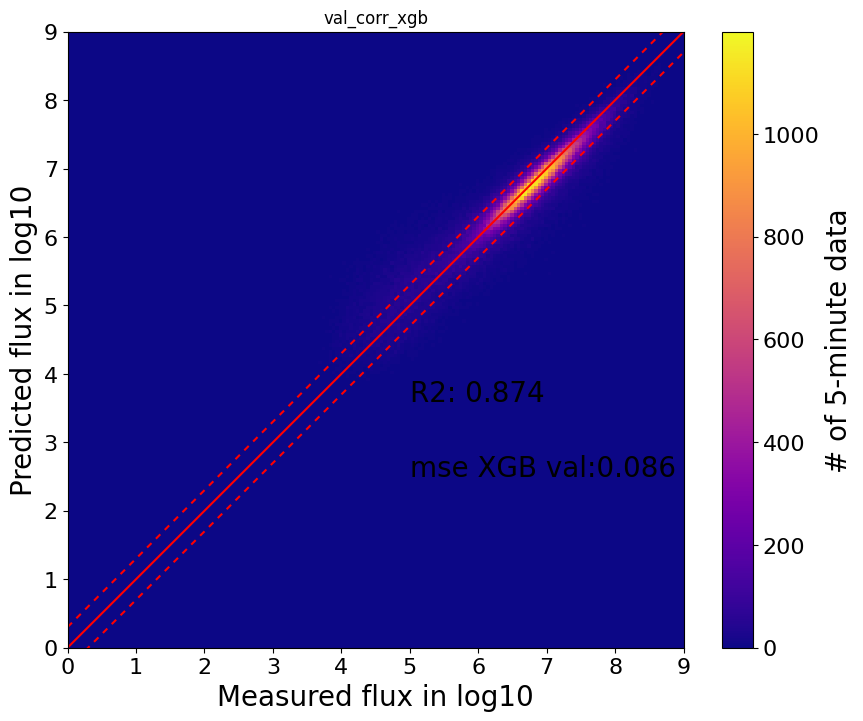

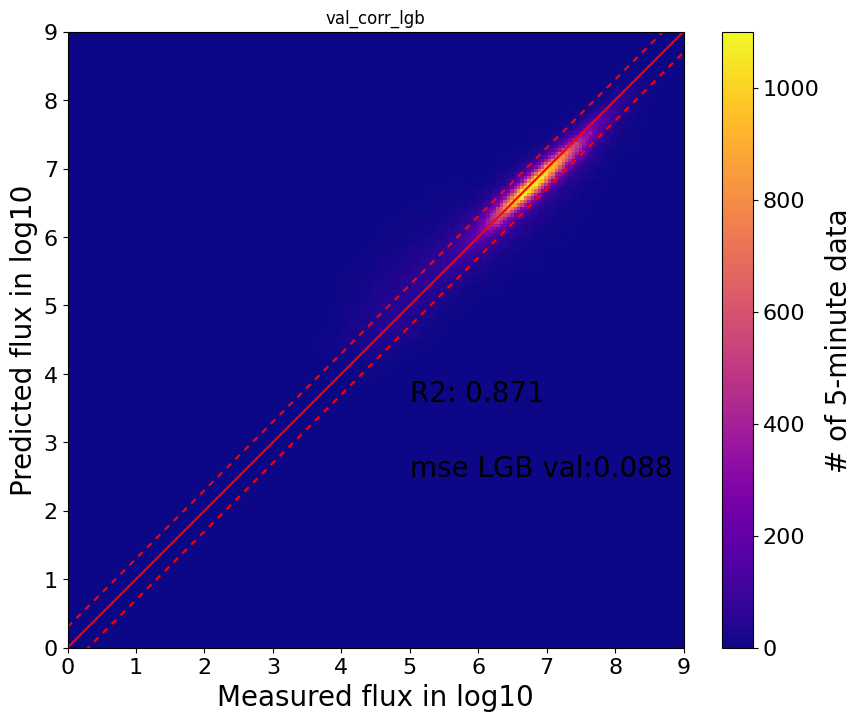

In [80]:
# predictions on validation, global modeling
y_val_xgb = bst_xgb.predict(dval_xgb)
y_val_lgb = bst_lgb.predict(X_val)

helperFunctions.plot_correlation_heatmap(y_val, y_val_xgb,
                        xrange=[0,9],
                        figname='val_corr_xgb',
                        data_type='XGB val')

helperFunctions.plot_correlation_heatmap(y_val, y_val_lgb,
                        xrange=[0,9],
                        figname='val_corr_lgb',
                        data_type='LGB val')


In [ ]:
# saving metrics
perL_models = {}
perL_metrics = []

for (lmin, lmax) in l_sets:
    
    mask = (df_data['L_floor'] >= lmin) & (df_data['L_floor'] <= lmax)
    n_total = int(mask.sum())

    train_mask_grp = mask & df_data.index.isin(idx_train)
    n_train = int(train_mask_grp.sum())
    print(f"Training L-shells {lmin}-{lmax} (n_train={n_train}, total_in_group={n_total})")

    # remaking subsets of training data
    df_grp_train = df_data.loc[train_mask_grp]

    Xg_train = df_grp_train[features].values
    yg_train = df_grp_train[log_y_name].values

    # Use VAL rows *within the group* as validation if available (preferred)
    val_mask_grp = mask & df_data.index.isin(idx_val)
    n_val = int(val_mask_grp.sum())

    # Use group-specific val rows from the global val set
    Xg_val = df_data.loc[val_mask_grp, features].values
    yg_val = df_data.loc[val_mask_grp, log_y_name].values

    dgtrain = xgb.DMatrix(Xg_train, label=yg_train, feature_names=features)
    dgval   = xgb.DMatrix(Xg_val,   label=yg_val,   feature_names=features)
    bst_grp = xgb.train(XGB_PARAMS, dgtrain, num_boost_round=8000, evals=[(dgval,'val')], early_stopping_rounds=50, verbose_eval=False)

    perL_models[(lmin,lmax)] = {'xgb': bst_grp, 'sectors': {}}
    r2_v = r2_score(yg_val, bst_grp.predict(dgval))
    perL_metrics.append({'group':f'{lmin}-{lmax}','n_train':int(n_train),'n_total':int(n_total),'val_r2':float(r2_v)})
    print(f"  group val_r2={r2_v:.3f} (n_train={n_train}, n_val={n_val})")

    # training within sectors within l-shell range, right before, global for this l-shell range was also trained
    if (lmin,lmax) == (4,6):
        # further split into sectors
        df_grp_train = df_grp_train.copy()
        df_grp_train['mlt_sector'] = df_grp_train['mlt'].apply(helperFunctions.assign_sector)

        for sector in ['dawn','day','dusk','night']:
            mask_s_train = df_grp_train['mlt_sector'] == sector
            ns_train = int(mask_s_train.sum())

            # sector training data
            Xs_train = df_grp_train.loc[mask_s_train, features].values
            ys_train = df_grp_train.loc[mask_s_train, log_y_name].values

            # prefer VAL-sector rows from global VAL if available
            val_mask_s = (mask & df_data.index.isin(idx_val)) & (df_data['mlt'].apply(helperFunctions.assign_sector) == sector)
            n_val_s = int(val_mask_s.sum())

            
            Xs_val = df_data.loc[val_mask_s, features].values
            ys_val = df_data.loc[val_mask_s, log_y_name].values

            ds_train = xgb.DMatrix(Xs_train, label=ys_train, feature_names=features)
            ds_val   = xgb.DMatrix(Xs_val,   label=ys_val,   feature_names=features)
            bst_sec = xgb.train(XGB_PARAMS, ds_train, num_boost_round=6000, evals=[(ds_val,'val')], early_stopping_rounds=40, verbose_eval=False)
            perL_models[(lmin,lmax)]['sectors'][sector] = {'model': bst_sec, 'n_train': int(ns_train)}
            print(f"sector {sector} val_r2={r2_score(ys_val, bst_sec.predict(ds_val)):.3f} n_train={ns_train}")


In [ ]:
perL_val = stackedFunctions.compute_perL_preds_for_indices(idx_val, df_data, perL_models, features, bst_xgb)

# usage (after val_df built)
df_val_local = df_data.loc[idx_val].reset_index(drop=True)
# fit calibrators for each base model
cal_xgb = stackedFunctions.fit_perL_calibrators(df_val_local, y_val, y_val_xgb)
cal_lgb = stackedFunctions.fit_perL_calibrators(df_val_local, y_val, y_val_lgb)
cal_perL = stackedFunctions.fit_perL_calibrators(df_val_local, y_val, perL_val)

# apply calibrations
y_val_xgb_cal  = stackedFunctions.apply_calibration(y_val_xgb, df_val_local, cal_xgb)
y_val_lgb_cal  = stackedFunctions.apply_calibration(y_val_lgb, df_val_local, cal_lgb)
perL_val_cal   = stackedFunctions.apply_calibration(perL_val,  df_val_local, cal_perL)

# Replace usage: use calibrated preds for stacking and summary
val_df = pd.DataFrame({
    'y_true': y_val,
    'xgb_global': y_val_xgb_cal,
    'lgb_global': y_val_lgb_cal,
    'perL_pred': perL_val_cal
})

calibrators_bundle = {'xgb': cal_xgb, 'lgb': cal_lgb, 'perL': cal_perL}

# grid search for grid ensemble
best_grid = {'w':None,'r2': -1e9}
ws = np.linspace(0,1,21)
for w1 in ws:
    for w2 in ws:
        if w1 + w2 > 1.0: continue
        w3 = 1.0 - w1 - w2
        pred = w1*val_df['xgb_global'].values + w2*val_df['lgb_global'].values + w3*val_df['perL_pred'].values
        r2v = r2_score(val_df['y_true'].values, pred)
        if r2v > best_grid['r2']:
            best_grid = {'w':(w1,w2,w3),'r2':r2v}
print("best grid ensemble weights:", best_grid['w'], "val R2:", best_grid['r2'])

# Ridge stacking meta-model
X_meta_val = val_df[['xgb_global','lgb_global','perL_pred']].values
y_meta_val = val_df['y_true'].values
ridge = RidgeCV(alphas=np.logspace(-6,2,30), cv=5)
ridge.fit(X_meta_val, y_meta_val)
meta_w = ridge.coef_
intercept = ridge.intercept_
print("best ridge stacking weights:", meta_w, "intercept:", intercept)

# evaluation
yval_grid  = best_grid['w'][0]*val_df['xgb_global'].values + best_grid['w'][1]*val_df['lgb_global'].values + best_grid['w'][2]*val_df['perL_pred'].values
yval_stack = ridge.predict(X_meta_val)
print("Grid ensemble val R2:", r2_score(val_df['y_true'].values, yval_grid), "MSE:", mean_squared_error(val_df['y_true'].values, yval_grid))
print("Stacked (Ridge) val R2:", r2_score(val_df['y_true'].values, yval_stack), "MSE:", mean_squared_error(val_df['y_true'].values, yval_stack))

helperFunctions.plot_correlation_heatmap(val_df['y_true'].values, yval_grid,
                     xrange=[0,9],
                     figname=os.path.join(stacked_model,'val_corr_ensemble_grid'),
                     data_type='ensemble_grid_val')

residuals = val_df['y_true'].values - yval_grid

plt.figure(figsize=(10,6))
plt.scatter(yval_grid, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

helperFunctions.plot_correlation_heatmap(val_df['y_true'].values, yval_stack,
                     xrange=[0,9],
                     figname=os.path.join(stacked_model,'val_corr_ensemble_stack'),
                     data_type='stack_val')

residuals = val_df['y_true'].values - yval_stack

plt.figure(figsize=(10,6))
plt.scatter(yval_stack, residuals, alpha=0.5, color="blue")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Save predictions and artifacts for VALIDATION set (instead of test)
val_out = df_data.loc[idx_val].copy().reset_index(drop=True)
val_out['y_true'] = y_val
val_out['xgb_global'] = val_df['xgb_global'].values
val_out['lgb_global'] = val_df['lgb_global'].values
val_out['perL_pred'] = val_df['perL_pred'].values
val_out['ensemble_grid'] = yval_grid
val_out['ensemble_stack'] = yval_stack
val_out.to_csv(os.path.join(stacked_model,'val_predictions_fixed.csv'), index=False)

joblib.dump({'bst_xgb':bst_xgb,'bst_lgb':bst_lgb,'perL_models':perL_models,'ridge_stack':ridge,'features':features, 'calibrators':calibrators_bundle}, os.path.join(stacked_model,'models_fixed.pkl'))

# per-L R2 for stacked predictions
r2_by_L = val_out.groupby('L_floor').apply(lambda g: r2_score(g['y_true'], g['ensemble_stack']) if len(g)>10 else np.nan)
print("Per-L stacked R2:")
print(r2_by_L)

# supplementary heatmaps
val_out['mlt_hour'] = np.floor(val_out['mlt']).astype(int)
val_out['error'] = val_out['y_true'] - val_out['ensemble_stack']
heat = val_out.pivot_table(index='L_floor', columns='mlt_hour', values='error', aggfunc='mean')

plt.figure(figsize=(12,6))
plt.imshow(heat.fillna(0), aspect='auto', cmap='coolwarm', vmin=-np.nanmax(np.abs(heat.values)), vmax=np.nanmax(np.abs(heat.values)))
plt.colorbar(label='residual mean (obs - pred)')
plt.xlabel('MLT hour'); plt.ylabel('L_floor'); plt.title('Residual mean heatmap (stacked fixed, VAL)')
plt.xticks(np.arange(24))
plt.yticks(np.arange(len(heat.index)), heat.index)
plt.savefig(os.path.join(stacked_model,'resid_heatmap_stacked_fixed_val.png'), dpi=200, bbox_inches='tight')
plt.close()

# summary
summary = {
    'global_xgb_val_r2': float(r2_score(y_val, y_val_xgb_cal)),
    'global_lgb_val_r2': float(r2_score(y_val, y_val_lgb_cal)),
    'grid_val_r2': float(best_grid['r2']),
    'grid_val_mse': float(mean_squared_error(val_df['y_true'].values, yval_grid)),
    'stacked_val_r2': float(r2_score(val_df['y_true'].values, yval_stack)),
    'stacked_val_mse': float(mean_squared_error(val_df['y_true'].values, yval_stack)),
    'n_total': int(len(df_data))
}

print(summary)